<a href="https://colab.research.google.com/github/BryanLJH-study/FIT5230_Assignment/blob/main/PatchCraft/TTI_Detector_PatchCraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group: Light TTI

This notebook implements the AI image detector described in the following paper: <br>
[**"PatchCraft: Exploring Texture Patch for Efficient AI-generated Image Detection"**](https://arxiv.org/abs/2311.12397) <br><br>

**Note:**
- The original paper does not provide an implementation.
- Therefore, we have created and trained our own model from scratch, as shown in the code below.
- Some sections in Parts 5 & 6 (Training & Testing) have been commented out, as running them is unnecessary for demonstration purposes.
- If you want to try out our model, you can skip to Part 7, where we provide a pretrained model for demonstration.

# Import Libraries

In [1]:
import os
import random as rand
from datetime import datetime

import numpy as np
import cv2
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd

import torch
import torchvision
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 1: Download Data

Clone prepared images from GitHub repository
- 1000 AI-Generated images from https://github.com/poloclub/diffusiondb/tree/main
- 1000 Real images from https://www.tensorflow.org/datasets/catalog/imagenet_v2

In [2]:
# Clone images and pretrained model from github repository
!git clone --depth 1  https://github.com/BryanLJH-study/FIT5230_Assignment.git images_repo
!mv images_repo/images .
!mv images_repo/PatchCraft/pretrained_example .
!rm -rf images_repo


Cloning into 'images_repo'...
remote: Enumerating objects: 2028, done.
remote: Counting objects: 100% (2028/2028), done.
remote: Compressing objects: 100% (2026/2026), done.
remote: Total 2028 (delta 2), reused 2027 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (2028/2028), 984.85 MiB | 24.83 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (2025/2025), done.


Display Sample Images

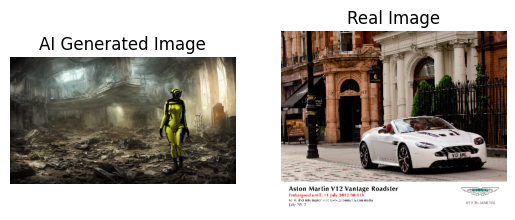

In [3]:
# Paths for each image class
AI_IMG_PATH = '/content/images/ai/'
REAL_IMG_PATH = '/content/images/real/'


# Sample an image from each class
ai_img_sample = cv2.imread(AI_IMG_PATH + os.listdir(AI_IMG_PATH)[0])
real_img_sample = cv2.imread(REAL_IMG_PATH + os.listdir(REAL_IMG_PATH)[0])
ai_img_sample = cv2.cvtColor(ai_img_sample, cv2.COLOR_BGR2RGB)
real_img_sample = cv2.cvtColor(real_img_sample, cv2.COLOR_BGR2RGB)


# Display images
def imshow(ai_img, real_img, title=None, subtitles=None, axes=True, cmap='viridis'):
  """
  Display two images side by side
  """
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(ai_img, cmap=cmap)
  ax[1].imshow(real_img, cmap=cmap)

  if title != None:
    fig.suptitle(title, fontweight='bold')
    fig.subplots_adjust(top=1)

  if subtitles != None:
    ax[0].set_title(subtitles[0])
    ax[1].set_title(subtitles[1])

  if axes == False:
    ax[0].axis('off')
    ax[1].axis('off')

  plt.show()

imshow(ai_img_sample, real_img_sample, subtitles=('AI Generated Image', 'Real Image'), axes=False)

# 2: Preprocesing Functions

**Summary of process:**
1. Extract 192 Random Patches of size 32x32 from image
2. Sort patches by texture diversity score (calculated using pixel fluctuation degree)
3. Divide patches into 2 groups based on texture diversity:
  - poor texture patches (bottom 33%)
  - rich texture patches (top 33%)
4. Combine patches from each group into two 256x256 images (poor and rich textures).
5. Apply 30 high pass filters to extract the noise patterns of both poor and rich texture images <br>


**Purpose**:
- The objective of this preprocessing step is to isolate and emphasize the distinct texture features present in "rich texture regions" and "poor texture regions.

- "Smashing and Reconstrucing" the image supresses the image's semantic information, and allows the detector to focus on the inter-pixel correlation of images instead.

- High-Pass Filtering helps to further suppress semantic information while amplifying the inter-pixel correlations. This process effectively highlights high-frequency noise patterns in both textures, preparing it for fingerprint extraction in the following layers.

## 2.1: Smash & Reconstruct

**Patch Extraction & Combining Functions**

In [4]:
def random_patches(img, num_patches=192, patch_size=32):
  """
  Returns a list of randomly cropped patches from an image.
  """
  height, width, _ = img.shape
  patches = []
  for _ in range(num_patches):
    x = rand.randint(0, width - patch_size)
    y = rand.randint(0, height - patch_size)
    patch = img[y:y + patch_size, x:x + patch_size]
    patches.append(patch)

  return patches


def combine_patches(patches, rows=8, cols=8):
  """
  Combines the image patches into a single image collage of gridsize=(rows,cols)
  """
  # Preparing image canvas
  patch_height, patch_width, _ = patches[0].shape
  grid_height = patch_height * rows
  grid_width = patch_width * cols
  grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)

  # Fill image canvas patch by patch
  for i, patch in enumerate(patches[:rows * cols]):
    row = i // cols
    col = i % cols
    y = row * patch_height
    x = col * patch_width
    grid_img[y:y + patch_height, x:x + patch_width] = patch

  return grid_img

Visualizing the patch extraction process using the sample images

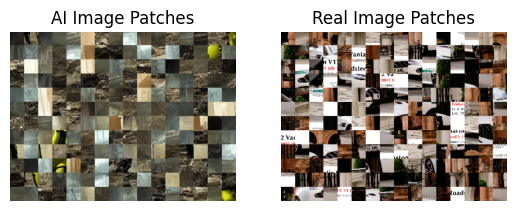

In [5]:
# Extact patches from samples
ai_patches = random_patches(ai_img_sample)
real_patches = random_patches(real_img_sample)

# Combine patches from samples into an images
ai_patches_combined = combine_patches(ai_patches, rows=12, cols=16)
real_patches_combined = combine_patches(real_patches, rows=12, cols=16)

# Display images
imshow(ai_patches_combined, real_patches_combined, subtitles=("AI Image Patches", "Real Image Patches"), axes=False)

**Rich & Poor Texture Regions Extraction Functions**

 Each patch's texture diversity score is calculated using the pixel fluctuation degree formula shown below.

 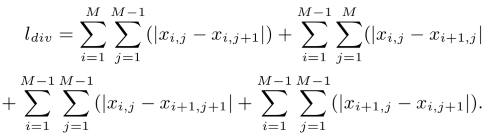

In [6]:
def texture_diversity(patch):
  """
  Measures texture diversity of a patch (square) by pixel fluctuation degree.
  Texture diversity score = sum of residuals of four directions (horizontal, vertical, diagonal, counter diagonal)

  Args:
    patch: A M x M numpy array representing the patch.

  Returns:
    The texture diversity score of the patch.

  Note: numpy is arrays have shape (height, width), which is why i & j are swapped from formula
  """
  patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
  patch = patch.astype(int)

  m, _ = patch.shape
  residual_sum = 0

  # Horizontal direction
  for i in range(m-1):
    for j in range(m):
      residual_sum += abs(patch[j][i] - patch[j][i+1])

  # Vertical direction
  for i in range(m):
    for j in range(m-1):
      residual_sum += abs(patch[j][i] - patch[j+1][i])

  # Diagonal & Counter-diagonal direction
  for i in range(m - 1):
    for j in range(m - 1):
      residual_sum += abs(patch[j][i] - patch[j+1][i+1])
      residual_sum += abs(patch[j+1][i] - patch[j][i+1])

  return residual_sum


def extract_rich_and_poor_textures(patches):
  """
  Sorts patches based on texture diversity and divides them into rich and poor texture patches.

  Args:
    patches: A list of image patches (numpy arrays).

  Returns:
    A tuple containing two lists: rich_patches and poor_patches.
  """
  # Calculate texture diversity scores for each patch
  diversity_scores = [texture_diversity(patch) for patch in patches]

  # Sort patches based on their texture diversity scores
  sorted_patches_with_scores = sorted(zip(patches, diversity_scores), key=lambda x: x[1])

  # Divide patches into  poor (bottom 33%) and rich (top 33%) texture patches
  num_patches = len(patches)
  poor_patches = [patch for patch, _ in sorted_patches_with_scores[:num_patches // 3]]
  rich_patches = [patch for patch, _ in sorted_patches_with_scores[2 * num_patches // 3:]]

  return poor_patches, rich_patches

**Overalll Smash & Reconstruct Function**

In [7]:
def smash_and_reconstruct(img):
  """
  Performs entire Smash & Reconstruct process on an image.

  Args:
    img: A numpy array representing the input image.

  Returns:
    A tuple containing two numpy arrays for poor and rich texture regions respectively.
  """
  # Extract rich & poor texture patches
  patches = random_patches(img, num_patches=192, patch_size=32)
  poor_patches, rich_patches = extract_rich_and_poor_textures(patches)

  # Recombine patches into images
  poor_img = combine_patches(poor_patches, rows=8, cols=8)
  rich_img = combine_patches(rich_patches, rows=8, cols=8)

  return poor_img, rich_img

Visualizing the Smash & Reconstruct process using sample images

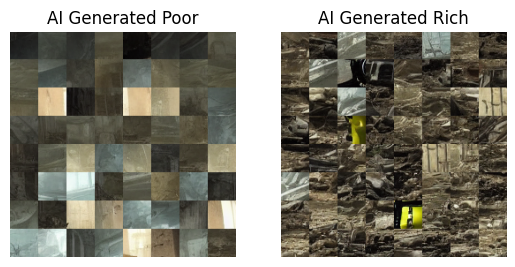

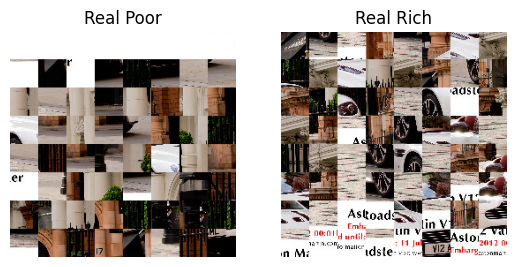

In [8]:
# Smash & Reconstruct
ai_poor, ai_rich = smash_and_reconstruct(ai_img_sample)
real_poor, real_rich = smash_and_reconstruct(real_img_sample)

# Display poor and rich texture from samples
imshow(ai_poor, ai_rich, subtitles=("AI Generated Poor", "AI Generated Rich"), axes=False)
imshow(real_poor, real_rich, subtitles=("Real Poor", "Real Rich"), axes=False)

## 2.2: High Pass Filters

**Define Filters** <br>
These 7 high pass filters will be rotated in various directions to form a total 30 filters. <br>
Note: based on filters proposed by Spatial Rich Model (SRM)

In [9]:
# Base Filters
filter_a = np.array([[ 0,  0,  0,  0,  0],
                     [ 0,  0,  1,  0,  0],
                     [ 0,  0, -1,  0,  0],
                     [ 0,  0,  0,  0,  0],
                     [ 0,  0,  0,  0,  0]])

filter_b = np.array([[ 0,  0, -1,  0,  0],
                     [ 0,  0,  3,  0,  0],
                     [ 0,  0, -3,  0,  0],
                     [ 0,  0,  1,  0,  0],
                     [ 0,  0,  0,  0,  0]])

filter_c = np.array([[ 0,  0,  0,  0,  0],
                     [ 0,  0,  1,  0,  0],
                     [ 0,  0, -2,  0,  0],
                     [ 0,  0,  1,  0,  0],
                     [ 0,  0,  0,  0,  0]])

filter_d = np.array([[ 0,  0,  0,  0,  0],
                     [ 0, -1,  2, -1,  0],
                     [ 0,  2, -4,  2,  0],
                     [ 0,  0,  0,  0,  0],
                     [ 0,  0,  0,  0,  0]])

filter_e = np.array([[-1,  2, -2,  2, -1],
                     [ 2, -6,  8, -6,  2],
                     [-2,  8,-12,  8, -2],
                     [ 0,  0,  0,  0,  0],
                     [ 0,  0,  0,  0,  0]])

filter_f = np.array([[ 0,  0,  0,  0,  0],
                     [ 0, -1,  2, -1,  0],
                     [ 0,  2, -4,  2,  0],
                     [ 0, -1,  2, -1,  0],
                     [ 0,  0,  0,  0,  0]])

filter_g = np.array([[-1,  2, -2,  2, -1],
                     [ 2, -6,  8, -6,  2],
                     [-2,  8,-12,  8, -2],
                     [ 2, -6,  8, -6,  2],
                     [-1,  2, -2,  2, -1]])


def filter_variations(base_filters, directions_list):
  """
  Generates a list of filters by rotating the base filters in various directions.

  Args:
    base_filters: A list of numpy arrays representing the base filters.
    directions_list: A list of lists representing the directions for rotation.
      - 0 = No rotation,
      - 1 = 45 degrees,
      - 2 = 90 degrees,
      - 3 = 135 degrees,
      - 4 = 180 degrees,
      - 5 = 225 degrees,
      - 6 = 270 degrees,
      - 7 = 315 degrees.

  Returns:
    A list of rotated filters.
  """
  angles= [-i*45 for i in range(8)]
  filters = []

  # Get each filter for each base fiter, for each rotation
  for base_filter, directions in zip(base_filters, directions_list):
    for d in directions:
      filter = rotate(base_filter, angle=angles[d], reshape=False)
      filters.append(filter)
  return filters

**Filter Application Functions**

In [10]:
def apply_filters(img, base_filters, directions_list):
  """
  Applies a list of filters to an image.

  Args:
    img: A numpy array representing the input image.
    base_filters: A list of numpy arrays representing the base filters.
    directions_list: A list of lists representing the directions for rotation.

  Returns:
    The extracted features in a 3D numpy array of shape (C, H, W).
  """
  result = []

  # Obtain complete filter list
  filters = filter_variations(base_filters, directions_list)

  # For each filter, convert image to greyscale and apply filter
  for filter in filters:
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filtered_img = cv2.filter2D(src=img_grey, kernel=filter, ddepth=-1)
    result.append(filtered_img)

  # Convert list of filters into a single 3d numpy array
  result = np.dstack(result)
  result = np.rollaxis(result,-1) # shape (H, W, C) -> (C, H, W) for pytorch

  return result


def apply_high_pass_filters(img):
  """
  Applies all 30 high pass filters to an image.

  Args:
    img: A numpy array representing the input image.

  Returns:
    The extracted features in a 3D numpy array of shape (C, H, W).
  """
  # Define high pass fiters
  base_filters = [filter_a, filter_b, filter_c, filter_d, filter_e, filter_f, filter_g]

  directions_list = [[i for i in range(8)],
                    [i for i in range(8)],
                    [1,2,3,4],
                    [0,2,4,6],
                    [0,2,4,6],
                    [0],
                    [0]]

  # Apply fiterss
  img_filtered = apply_filters(img, base_filters, directions_list)

  return img_filtered

Visualize high pass filtered poor and rich texture regions of sample images

In [11]:
# Apply high pass filters to poor and rich texture region images  of both samples
ai_poor_hpf = apply_high_pass_filters(ai_poor)
ai_rich_hpf = apply_high_pass_filters(ai_rich)
real_poor_hpf = apply_high_pass_filters(real_poor)
real_rich_hpf = apply_high_pass_filters(real_rich)

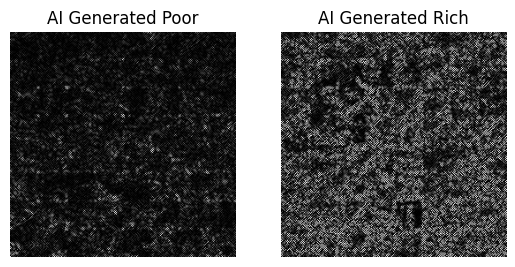

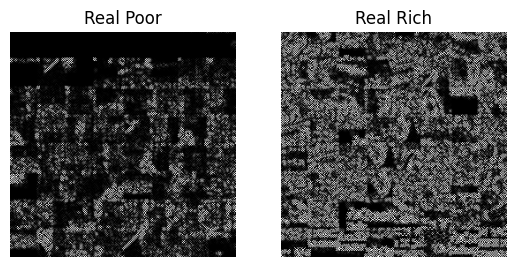

In [12]:
filter_no = 29  # Change to visualize filters (0 - 29)

# Display filtered images
imshow(ai_poor_hpf[filter_no], ai_rich_hpf[filter_no], subtitles=("AI Generated Poor", "AI Generated Rich"), axes=False, cmap='gray')
imshow(real_poor_hpf[filter_no], real_rich_hpf[filter_no], subtitles=("Real Poor", "Real Rich"), axes=False, cmap='gray')

## 2.3: Overall Preprocessing

In [13]:
def preprocess(img):
  """
  Wrapper function for image preprocessing.

  Args:
    img: The input image

  Returns:
    A tuple containing two numpy arrays of shape (C, H, W) for poor and rich texture regions respectively.
  """
  # Convert input image into numpy array
  img = np.array(img)

  # Extract poor and rich texture regions, and apply high pass filters
  poor, rich = smash_and_reconstruct(img)
  poor = apply_high_pass_filters(poor)
  rich = apply_high_pass_filters(rich)

  return poor, rich


class Preprocess:
  """
  Custom class to preprocess images in ImageFolder dataloader
  """
  def __init__(self):
      pass

  def __call__(self, img):
      poor, rich = preprocess(img)
      return poor, rich

# 3: Data Pipeline

## 3.1: Define Data Pipeline

**Load and Transform Data**

In order to improve the generalizability of the model, 3 data augmentations (with 10% probabilty each) are performed on the training images
- JPEG compression (QF∼Uniform[70, 100]),
- Gaussianblur (σ∼Uniform[0,1])
- Downsampling (r∼Uniform[0.25, 0.5])

In [14]:
# Custom downsampling augmentation function
class Downsampling:
    def __init__(self, scale_range=(0.25, 0.5)):
        self.scale_range = scale_range

    def __call__(self, img):
        # Calculate random downsampling factor
        scale_factor = rand.uniform(*self.scale_range)
        width, height = img.size
        new_size = (int(width * scale_factor), int(height * scale_factor))

        # Downsample and then upscale back to original size
        img = v2.functional.resize(img, new_size)
        img = v2.functional.resize(img, (height, width))
        return img

# Define Transformations: Data Augmentations & Preprocessing
transforms = v2.Compose([
    v2.RandomApply([v2.JPEG(quality=(70, 100))], p=0.1),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.00000001, 1.0))], p=0.1),
    v2.RandomApply([Downsampling(scale_range=(0.25, 0.5))], p=0.1),
    Preprocess()
])

# Load & transforms images following directory arrangement: root/classA/xxx.png...
#                                                           root/classB/xxx.png...
img_data = ImageFolder(root='images', transform=transforms)

# Reduce the size of the dataset by selecting a subset (Comment out if unneeded)
# SUBSET_SIZE = 200
# subset_indices = torch.randperm(len(img_data))[:SUBSET_SIZE]
# subset_data = Subset(img_data, subset_indices)

**Train-Validation-Test Split**

In [15]:
# Split dataset into training, validation, and test sets (70:15:15 split)
train_size = int(0.7 * len(img_data))
val_size = int(0.15 * len(img_data))
test_size = val_size

train_data, val_data, test_data = random_split(img_data, [train_size, val_size, test_size])

In [16]:
# Subset version (Comment out if not using subset)
# train_size = int(0.7 * SUBSET_SIZE)
# val_size = int(0.15 * SUBSET_SIZE)
# test_size = val_size
# train_data, val_data, test_data = random_split(subset_data, [train_size, val_size, test_size])

**Batch & Shuffle Data**

In [17]:
BATCH_SIZE = 32

train_data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_data= DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## 3.2 Checking Data Pipeline

In [18]:
# Get first batch of training data
batch = next(iter(train_data))

# Print details
print(f"No. of batches: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)} \n")

print("Batch Dimensions")
print(f"poor texture tensor: {batch[0][0].shape}") # dims = (B, C, H, W)
print(f"rich texture tensor: {batch[0][1].shape}") # dims = (B, C, H, W)
print(f"lables tensor = {batch[1].shape}")

No. of batches: Train=44, Val=10, Test=10 

Batch Dimensions
poor texture tensor: torch.Size([32, 30, 256, 256])
rich texture tensor: torch.Size([32, 30, 256, 256])
lables tensor = torch.Size([32])


## 4: Model

**Model Architecture**
- Fingerprint Extractor
  - The fingerprint of the image is denoted by the inter-pixel correlation contrast between the rich and poor texture regions.
  - To extract this fingerprint, the preprocessed poor and rich texture inputs are passed through separate learnable convolution blocks. These blocks learn to identify texture-specific features from each input. The outputs (residuals) from these blocks are then subtracted, producing a residual fingerprint that emphasizes the texture discrepancies between rich and poor regions.

- Classifier
  - For classification, the model uses cascading convolutional blocks to progressively refine the extracted features
  - Pooling layers are used sparingly to preserve as much of the fine-grained texture information as possible. Since pooling reduces the spatial dimensions of feature maps, excessive pooling could destroy important artifacts necessary for accurate detection.

## 4.1: Define PatchCraft Model

In [19]:
class PatchCraftModel(nn.Module):
  def __init__(self):
     super(PatchCraftModel, self).__init__()

     # Convolution block learns inter-pixel correlation from the input high-pass filtered images
     self.hpv_extraction_block = nn.Sequential(
        nn.Conv2d(30, 1, kernel_size=3, bias=False),
        nn.BatchNorm2d(1),
        nn.Hardtanh(),
     )
     # First convolution blocks of classifier
     self.double_conv_block_1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, bias=False), # Bias = False because it is redundant when followed by BatchNorm
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
     )
     # Convolution blocks
     self.double_conv_block = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
     )
     # Pooling layers
     self.AvgPool = nn.AvgPool2d(kernel_size=2)
     self.AdpAvgPool = nn.AdaptiveAvgPool2d((1,1))

     # Flattening & Fully Connected Layers
     self.flatten = nn.Flatten()
     self.fc = nn.Linear(32, 1)


  def forward(self, poor_texture, rich_texture):
    # Extract inter-pixel correlation from high pass fiters processed poor and rich texture regions
    poor_features = self.hpv_extraction_block(poor_texture)
    rich_features = self.hpv_extraction_block(rich_texture)

    # Fingerprint: inter-pixel correlation contrast between rich and poor texture regions
    fingerprint = rich_features - poor_features

    # Classifier
    x = self.double_conv_block_1(fingerprint)

    for _ in range(3):
      x = self.double_conv_block(x)
      x = self.AvgPool(x)

    x = self.double_conv_block(x)
    x = self.AdpAvgPool(x)

    x = self.flatten(x)
    x = self.fc(x)

    return x

## 4:2: Initialize Model

In [20]:
# Configure pytorch to use GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# Initialize model
model = PatchCraftModel().to(device)

# Show summary of model
poor_input_dim = tuple(batch[0][0].shape)[1:]
rich_input_dim = tuple(batch[0][1].shape)[1:]
summary(model, input_size=[poor_input_dim, rich_input_dim])

Device cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 254, 254]             270
       BatchNorm2d-2          [-1, 1, 254, 254]               2
          Hardtanh-3          [-1, 1, 254, 254]               0
            Conv2d-4          [-1, 1, 254, 254]             270
       BatchNorm2d-5          [-1, 1, 254, 254]               2
          Hardtanh-6          [-1, 1, 254, 254]               0
            Conv2d-7         [-1, 32, 252, 252]             288
       BatchNorm2d-8         [-1, 32, 252, 252]              64
              ReLU-9         [-1, 32, 252, 252]               0
           Conv2d-10         [-1, 32, 250, 250]           9,216
      BatchNorm2d-11         [-1, 32, 250, 250]              64
             ReLU-12         [-1, 32, 250, 250]               0
           Conv2d-13         [-1, 32, 248, 248]           9,216
      BatchNorm2d-14        

# 5: Train Model

## 5.1: Define Training Functions

In [21]:
def train_one_epoch(train_data, loss_fn, optimizer):
  """
  Train model for one epoch.

  Returns
    - train_loss = training loss
    - train_acc = training accuracy
  """
  # Set model to training mode
  model.train()

  # Metrics variables
  running_loss = 0.0
  running_corrects = 0
  total_train = 0

  # For each batch...
  for inputs, labels in train_data:
    # Inputs and labels
    poor_texture = inputs[0].float().to(device)
    rich_texture = inputs[1].float().to(device)
    labels = labels.float().unsqueeze(1).to(device)  # Match output shape for BCE loss

    # Clear previous gradients
    for param in model.parameters():
        param.grad = None

    # Forward propogation
    outputs = model(poor_texture, rich_texture)
    loss = loss_fn(outputs, labels)                 # Compute loss

    # Backward propogation & optimization
    loss.backward()                                 # Backward propogation
    optimizer.step()                                # Adjust learning weights

    # Gather metrics and report
    running_loss += loss.item()
    predicted = torch.round(torch.sigmoid(outputs))
    running_corrects += (predicted == labels).sum().item()
    total_train += labels.size(0)

  train_loss = running_loss / total_train
  train_acc = running_corrects / total_train

  return train_loss, train_acc

In [22]:
def validate(val_data, loss_fn, optimizer):
  """
  Run model on validation data.

  Returns:
    - val_loss = validation loss
    - val_acc = validation accuracy
  """
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Metrics variables
  running_val_loss = 0.0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    # For each batch...
    for inputs, labels in val_data:
      poor_texture = inputs[0].float().to(device)
      rich_texture = inputs[1].float().to(device)
      labels = labels.float().unsqueeze(1).to(device)

      # Forward propagation
      outputs = model(poor_texture, rich_texture)
      loss = loss_fn(outputs, labels)

      # Metrics
      running_val_loss += loss.item()
      predicted = torch.round(torch.sigmoid(outputs))
      correct_val += (predicted == labels).sum().item()
      total_val += labels.size(0)

  val_loss = running_val_loss / total_val
  val_acc = correct_val / total_val

  return val_loss, val_acc

In [23]:
def train(epochs, config, checkpoint_dir=None, best_model_dir=None, writer_dir=None, continue_dir=None):
  """
  Training loop wrapper

  Args:
    - epochs = number of epochs to train
    - config = model configurations
    - checkpoint_dir = directory to save model checkpoints (optional)
    - best_model_dir = directory to save best model (optional)
    - writer_dir = directory to save tensorboard logs (optional)
    - continue_dir = directory to load model state from (optional)

  Returns:
    - training run_name
  """
  # Initialize Logging Variables
  run_name = f"patchcraft_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
  writer = SummaryWriter(writer_dir + run_name)

  # Define loss function, optimizer, and training variables
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=config['lr'])
  starting_epoch = 1
  best_val_loss = 1000000.0

  # If continuing from previous checkpoint, load state
  if continue_dir is not None:
      checkpoint = torch.load(continue_dir, weights_only=True)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      starting_epoch = checkpoint['epoch'] + 1

  # Train model
  for epoch in range(starting_epoch,epochs+1):
    train_loss, train_acc = train_one_epoch(train_data, loss_fn, optimizer)
    val_loss, val_acc = validate(val_data, loss_fn, optimizer)

    # Report & save metrics
    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {datetime.now().strftime('%m/%d %H:%M')}")

    writer.add_scalars('Loss', {'Training': train_loss, 'Validation': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Training': train_acc, 'Validation': val_acc}, epoch)
    writer.flush()

    # If val_loss is best so far, save model
    if best_model_dir is not None and val_loss < best_val_loss:
      best_val_loss = val_loss
      if not os.path.exists(best_model_dir):
        os.makedirs(best_model_dir)
      model_path = best_model_dir + run_name + '.pth'
      torch.save(model.state_dict(), model_path)

    # Save a checkpoint
    if checkpoint_dir is not None:
      if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
      model_path = checkpoint_dir + run_name + '.pth'
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
      }, model_path)

  writer.close()

  return run_name

## 5.2: Train model
Run Training Function

In [24]:
EPOCHS = 50
CONFIG = {'lr': 0.001}
CHECKPOINT_DIR = './models/checkpoints/'
BEST_MODEL_DIR = './models/best/'
WRITER_DIR = './runs/'

#run_name = train(EPOCHS, CONFIG, CHECKPOINT_DIR, BEST_MODEL_DIR, WRITER_DIR)

Load Best Model

In [25]:
# model.load_state_dict(torch.load(BEST_MODEL_DIR + run_name + '.pth'))

**Visualize Training Logs**

In [26]:
metrics = ['Loss_Training', 'Loss_Validation', 'Accuracy_Training', 'Accuracy_Validation']

def read_training_metrics(path):
  """
  Read training metrics from tensorboard logs.
  Returns a dataframe of metrics.
  """
  runlog_data = pd.DataFrame()

  for metric in metrics:
    ea = EventAccumulator(path+metric)
    ea.Reload()
    tags = ea.Tags()['scalars']
    for tag in tags:
      event_list = ea.Scalars(tag)
      epoch = list(map(lambda x: x.step, event_list))
      values = list(map(lambda x: x.value, event_list))
      r = {"epoch": epoch, metric: values}
      r = pd.DataFrame(r)
      if runlog_data.empty:
          runlog_data = r
      else:
          runlog_data = pd.merge(runlog_data, r, on='epoch')
  return runlog_data


def plot_training(df, train_col, val_col):
  """
  Plot training and validation metrics.
  """
  plt.plot(df['epoch'], df[train_col], label=train_col)
  plt.plot(df['epoch'], df[val_col], label=val_col)
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [27]:
# train_df = read_training_metrics(WRITER_DIR + run + '/')
# plot_training(train_df, metrics[0], metrics[1])
# plot_training(train_df, metrics[2], metrics[3])

## 6: Testing

In [28]:
def test(model, test_data):
  """
  Test model on test data.
  Reports accuracy, precision, recall, and confusion matrix.
  """
  # Set the model to evaluation mode
  model.eval()

  # Metrics variables
  all_preds = []
  all_labels = []

  with torch.no_grad():
    # For each batch...
    for features, labels in test_data:
      # Inputs and labels
      poor_texture = features[0].float().to(device)
      rich_texture = features[1].float().to(device)
      labels = labels.float().unsqueeze(1).to(device)

      # Forward propogation
      outputs = model(poor_texture, rich_texture)

      # Update metrics
      predicted = torch.round(torch.sigmoid(outputs))
      all_preds.extend(predicted.cpu().numpy().squeeze())    # Store predictions
      all_labels.extend(labels.cpu().numpy().squeeze())      # Store actual labels

  # Report metrics
  print(f"Test Accuracy: {sklearn.metrics.accuracy_score(all_labels, all_preds)}")
  print(f"Test Precision: {sklearn.metrics.precision_score(all_labels, all_preds)}")
  print(f"Test Recall: {sklearn.metrics.recall_score(all_labels, all_preds)}")

  # Compute confusion matrix
  cm = sklearn.metrics.confusion_matrix(all_labels, all_preds)

  # Display confusion matrix
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [29]:
# test(model, test_data)

# 7: Using Pretrained Model

For convience, we have provided a pretrained model to experiment with.

## 7.1 Import pretrained model

- The provided model is trained on 700 real images and 700 AI generated images from the dataset imported above.
- This is not ideal compared to the original paper's 720k training images.
- But this is the best we could work with, given our device's capabilities.


In [31]:
PRETRAINED_EXAMPLE_PATH = '/content/pretrained_example/'
PRETRAINED_MODEL_PATH = PRETRAINED_EXAMPLE_PATH + 'pretrained_patchcraft_model_700.pth'
pretrained_model = PatchCraftModel().to(device)
pretrained_model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))

<ipython-input-31-61e4847e1b71>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH, map_location=torch.device

<All keys matched successfully>

## 7.2: Running pretrained model on test data

### Test Accuracy

The pretrained model boasts an accuracy of around 80% on the testing data

The recall and precision scores are also quite balanced. Though recall is slightly higher, suggesting that the model is more focused on minimizing false negatives.

Test Accuracy: 0.7933333333333333
Test Precision: 0.7192982456140351
Test Recall: 0.8978102189781022


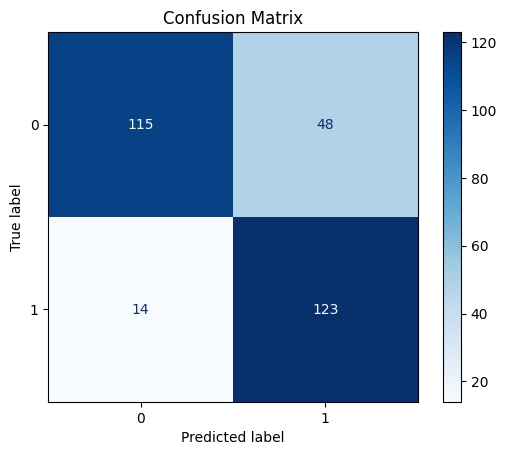

In [43]:
test(pretrained_model, test_data)

The training logs suggest that the model is likely overfitting due to the limited size of the training dataset.

Although the training loss continues to decreases, the validation loss plateaus early, indicating that the model is not generalizing well to unseen data.

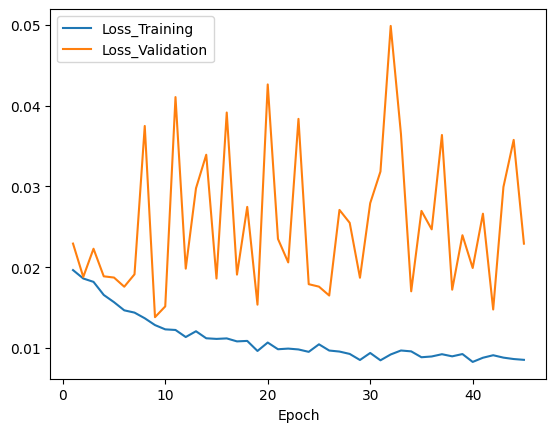

In [44]:
pretrained_df = read_training_metrics(PRETRAINED_EXAMPLE_PATH + 'training_log/')
plot_training(pretrained_df, metrics[0], metrics[1])

## 7.3: Pretrained Model Demonstration

**Define Functions**

In [35]:
def pretrained_patchcraft(img):
  """
  Classifies input image as real or AI generated.
  Returns
    - pred_class = 1 if real, 0 if AI generated
    - prob = probability of class 1
  """
  # Preprocess the image
  poor, rich  = preprocess(img)
  poor = torch.from_numpy(poor).unsqueeze(0).float().to(device)
  rich = torch.from_numpy(rich).unsqueeze(0).float().to(device)

  # Set model to evaluation mode
  pretrained_model.eval()

  # Pass the preprocessed image through the model
  with torch.no_grad():
    output = pretrained_model(poor, rich)
    prob= torch.sigmoid(output).item()    # Get the probability of class 1

  pred_class = 1 if prob >= 0.5 else 0

  return pred_class, prob


def is_real(img=None, path=None):
  """
  Wrapper function for pretrained_patchcraft.
  Displays image and prediction results.
  """
  # Read image if path provided
  if path is not None:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Define image display dimensions
  height = 2
  aspect_ratio = img.shape[1] / img.shape[0]  # width / height
  width = height * aspect_ratio

  # Display image
  plt.figure(figsize=(width, height))
  plt.imshow(img)
  plt.axis('off')

  # Report prediction results of image
  pred_class, prob = pretrained_patchcraft(img)

  if pred_class:
    print("Prediction: Real Image")
    print('Probability:', prob)

  else:
    print("Prediction: AI Generated Image")
    print('Probability:', 1-prob)

### Classifying AI Generated Images

The patchcraft model works well on classifying completely AI generated images as per its designed purpose, and the training dataset we prepared.

Prediction: AI Generated Image
Probability: 0.9342380240559578


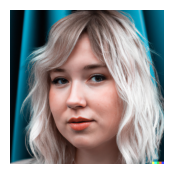

In [36]:
# Testing model on image generated by Dall-E 2
is_real(path=PRETRAINED_EXAMPLE_PATH + 'Dall-E_woman.png')

Prediction: Real Image
Probability: 0.6754194498062134


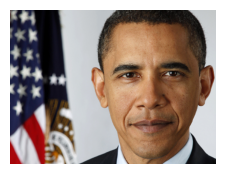

In [37]:
# Testing model on an image of a  real person
is_real(path=PRETRAINED_EXAMPLE_PATH + 'obama.png')

### Classifying AI-Manipulated (Tampered) Real Images
- Unfortunately, the model’s performance in detecting AI-manipulated real images largely depends on the extent of the manipulation.
- For instance, if the image has only been slightly altered, the PatchCraft model may lower its confidence in the image being real.
- However, this reduction in confidence might not be sufficient to classify the image as fake.

Prediction: Real Image
Probability: 0.6619123220443726


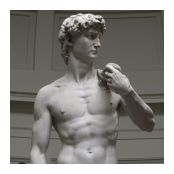

In [38]:
# Original real image
is_real(path=PRETRAINED_EXAMPLE_PATH + 'original_0.jpeg')

Prediction: Real Image
Probability: 0.5764557123184204


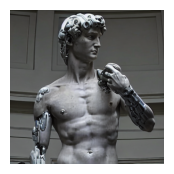

In [39]:
# Instruct Pix2Pix edited image  (Text CFG = 7.5,  Image CFG = 1.5) <- default values
is_real(path=PRETRAINED_EXAMPLE_PATH + 'pix2pix_0.png')

For Instruct Pix2Pix this means that the Image Classifier Free Guidance (CFG) weight (i.e. how similar the output should be to the input) significantly influences the model's classification performance.

In the example below, the real image was edited using Instruct Pix2Pix with the following configuration:
- Prompt: "Turn the image into a Picasso Painting"
- Text CFG: 7.5
- Image CFG: 1.5 (edited example 1), 3 (edited example 2)

Notice that the model successfully detects the more heavily manipulated image (with a lower Image CFG) but misclassifies the image that retains more of the original features.

Prediction: Real Image
Probability: 0.6635541915893555


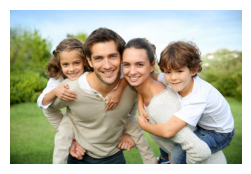

In [40]:
# Original real image
is_real(path=PRETRAINED_EXAMPLE_PATH + 'original_1.jpg')

Prediction: AI Generated Image
Probability: 0.7980767339468002


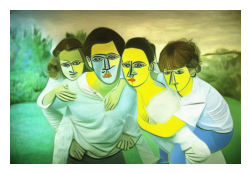

In [41]:
# Instruct Pix2Pix edited image (Text CFG = 7.5,  Image CFG = 1.5) <- default values
is_real(path=PRETRAINED_EXAMPLE_PATH + 'pix2pix_1_default.png')

Prediction: AI Generated Image
Probability: 0.5147890746593475


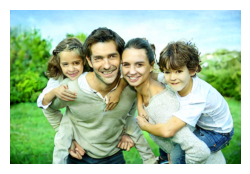

In [42]:
# Testing on Instruct Pix2Pix edited image (Text CFG = 7.5,  Image CFG = 3)
is_real(path=PRETRAINED_EXAMPLE_PATH + 'pix2pix_1_image_CFG_3.png')